In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
import sys
import gc
import torch
import random
warnings.filterwarnings("ignore")
base_dir = os.path.split(os.getcwd())[0]
sys.path.append(base_dir)

from pyfunctions.local_importance import *
from pyfunctions._integrated_gradients import configure_interpretable_embeddings, remove_interpretable_embeddings

In [3]:
# set up env
#!python3.12 -m pip install lime
#!python3.12 -m pip install shap
#!python3.12 -m pip install tf-keras==2.16.0
#!python3.12 -m pip install captum

In [4]:
torch.autograd.set_grad_enabled(False)

In [213]:
device = 'cuda:0'
supported_model_and_task = {"bert": ["pathology", "sst2", "agnews"], "gpt2": ["ioi"]}
model_type = 'gpt2' #"bert", "gpt2"
data_name = supported_model_and_task[model_type][0] #"bert""pathology", "sst2", "agnews", "ioi"

if data_name == "sst2":
    max_seq_len = 120
    class_names = ["0", "1"]
if data_name == "agnews":
    max_seq_len = 240
    class_names = ["0", "1", "2", "3"]
elif data_name == "pathology":
    max_seq_len = 512
    class_names = ["3", "4", "5"]
elif data_name == "ioi":
    max_seq_len = 16
    class_names = [str(token_id) for token_id in range(50257)]

In [214]:
# load in data and model
data, le_dict, tokenizer, model = load_data_and_model(data_name, model_type, device)

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda:0


## Compute dataset stats

In [ ]:
# Prepare AGNews-long
idx = []
for i, text in enumerate(data['docs']):
    text_ids = tokenizer.encode(text)
    if len(text_ids) > 150:
        idx.append(i)
    if len(idx) == 50:
        break

In [ ]:
len(idx)

In [259]:
idx = random.sample(range(len(data['docs'])), 34)
agnews_text_data_random, agnews_label_data_random = [], []
for i in idx:
    agnews_text_data_random.append(data['docs'][i])
    agnews_label_data_random.append(data['labels'][i])

In [ ]:
idx = random.sample(range(len(data['docs'])), 34)
sst2_text_data, sst2_label_data = [], []
for i in idx:
    sst2_text_data.append(data['docs'][i])
    sst2_label_data.append(data['labels'][i])

In [ ]:
idx = random.sample(range(len(data['docs'])), 34)
path_text_data, path_label_data = [], []
for i in idx:
    path_text_data.append(data['docs'][i])
    path_label_data.append(data['labels'][i])

In [ ]:
idx = random.sample(range(len(data.sentences)), 34)
ioi_sample_id = idx

In [260]:
sample_data_dict = {"ioi": ioi_sample_id, "sst2": sst2_text_data, "agnews": agnews_text_data, "agnews_rand": agnews_text_data_random, "pathology": path_text_data}

In [261]:
sample_labels_dict = {"ioi": None, "sst2": sst2_label_data, "agnews": agnews_label_data, "agnews_rand": agnews_label_data_random, "pathology": path_label_data}

In [ ]:
tot = []
for x in ["ioi", "sst2", "agnews", "pathology"]:
    sample_data = sample_data_dict[x]
    res = []
    for text in tqdm.tqdm(sample_data):
        if x == "ioi":
            # "text" is actually sample_id for ioi task
            text = data.sentences[text]
            text_ids = tokenizer.encode(text)
        else:
            text_ids = tokenizer.encode(text)
        res.append(len(text_ids))
    tot.append(res)

Text(0, 0.5, 'Token Counts')

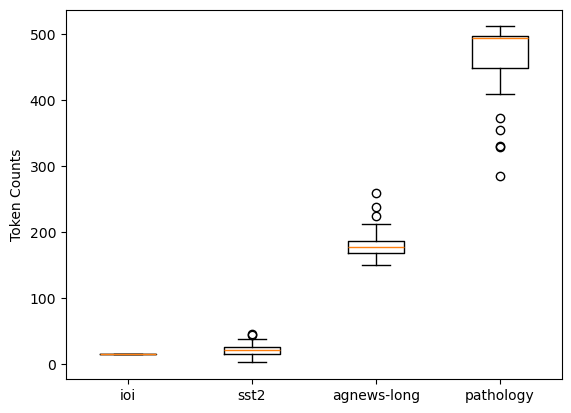

In [227]:
plot = matplotlib.pyplot.boxplot(tot, labels = ["ioi", "sst2", "agnews-long", "pathology"] )
matplotlib.pyplot.ylabel("Token Counts")

In [ ]:
np.median(tot, axis=1)

In [262]:
import json
# save sample data for reproducibility
with open('new_local_importance_sample_text.json', 'w') as f:
    json.dump(sample_data_dict, f)

with open('new_local_importance_sample_label.json', 'w') as f:
    json.dump(sample_labels_dict, f)

## Run local interpretation

In [265]:
with open('new_local_importance_sample_text.json', 'r') as f:
    sample_data_dict = json.load(f)
    
with open('new_local_importance_sample_label.json', 'r') as f:
    sample_labels_dict = json.load(f)

In [299]:
device = 'cuda:0'
supported_model_and_task = {"bert": ["pathology", "sst2", "agnews", "agnews_rand"], "gpt2": ["ioi"]}
model_type = 'bert' #"bert", "gpt2"
data_name = supported_model_and_task[model_type][3] #"bert""pathology", "sst2", "agnews", "ioi"

if data_name == "sst2":
    max_seq_len = 120
    class_names = ["0", "1"] #0: negative, 1: positive
elif data_name == "agnews":
    max_seq_len = 240
    class_names = ["0", "1", "2", "3"]
elif data_name == "agnews_rand":
    max_seq_len = 240
    class_names = ["0", "1", "2", "3"] #0: world, 1: sports, 2: business, 3: Sci/Tech
elif data_name == "pathology":
    max_seq_len = 512
    class_names = ["3", "4", "5"]
elif data_name == "ioi":
    max_seq_len = 16
    class_names = [str(token_id) for token_id in range(50257)]
    
# load in data and model
data, le_dict, tokenizer, model = load_data_and_model(data_name, model_type, device)

In [304]:
sample_data = sample_data_dict["pathology"][:10]
sample_labels = sample_labels_dict["pathology"][:10]
sample_labels

['3', '3', '3', '3', '3', '4', '4', '4', '3', '3']

In [300]:
import time
import tracemalloc

methods = ["lime", "shap", "CDT", "LIG"]

print(f'Running dataset {data_name}...')
sample_data = sample_data_dict[data_name][:10]
sample_labels = sample_labels_dict[data_name]

# check for these data: pred == gt_label
for gt_label, text in zip(sample_labels, sample_data):
    outputs = model(**tokenizer(text, 
                                 max_length=max_seq_len,
                                 truncation=True, 
                                 padding = "max_length", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device))
    tensor_logits = outputs[0]
    pred = torch.argmax(tensor_logits).detach().cpu().numpy()
    try:
        assert(gt_label, pred)
    except:
        print(gt_label, pred)
        
resource_use = {}
for method in methods[2:]:
    print(f'Running method {method}...')
    resource_use[method] = {'time': [], 'memory': []}
    for i in range(len(sample_data)):
        print("="*10 + f' sample {i} ' + "="*10)
        if data_name != "ioi":
            tokenized_prompt = None
            io_seq_idx = None
            s_seq_idx = None
            text = sample_data[i].strip().lower()
            label = sample_labels[i]
            label_idx = le_dict[label]
            tokenizer.pad_token = tokenizer.eos_token
        else:
            sample_id = sample_data[i]
            tokenized_prompt = data.tokenized_prompts[sample_id]
            io_seq_idx = data.io_tokenIDs[sample_id] # sample_id 0-50 for ioi
            s_seq_idx = data.s_tokenIDs[sample_id] 
            text = data.sentences[sample_id]
            label_idx = None

        # clear cache
        gc.collect()
        torch.cuda.empty_cache()
        
        # start monitoring memory and time
        tracemalloc.start()
        start_t = time.time()
        scores = run_local_importance(text, tokenized_prompt, io_seq_idx, s_seq_idx, label_idx, max_seq_len, model, tokenizer,
                              device, method, model_type, class_names)
        end_t = time.time()
        curr_mem, max_mem = tracemalloc.get_traced_memory()
        print("="*20)
        
        resource_use[method]['time'].append(end_t - start_t)
        resource_use[method]['memory'].append(max_mem/(1024*1024))
        tracemalloc.reset_peak()
        del curr_mem, max_mem

Running dataset agnews_rand...
Running method CDT...
========== sample 0 ==========


Running decomposition in batches...: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

Viz rel: 


Viz irrel: 


Viz rel-irrel: 


========== sample 1 ==========


Running decomposition in batches...: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

Viz rel: 


Viz irrel: 


Viz rel-irrel: 


========== sample 2 ==========


Running decomposition in batches...: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

Viz rel: 


Viz irrel: 


Viz rel-irrel: 


========== sample 3 ==========


Running decomposition in batches...: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

Viz rel: 


Viz irrel: 


Viz rel-irrel: 


========== sample 4 ==========


Running decomposition in batches...: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

Viz rel: 


Viz irrel: 


Viz rel-irrel: 


========== sample 5 ==========


Running decomposition in batches...: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

Viz rel: 


Viz irrel: 


Viz rel-irrel: 


========== sample 6 ==========


Running decomposition in batches...: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

Viz rel: 


Viz irrel: 


Viz rel-irrel: 


========== sample 7 ==========


Running decomposition in batches...: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

Viz rel: 


Viz irrel: 


Viz rel-irrel: 


========== sample 8 ==========


Running decomposition in batches...: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

Viz rel: 


Viz irrel: 


Viz rel-irrel: 


========== sample 9 ==========


Running decomposition in batches...: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

Viz rel: 


Viz irrel: 


Viz rel-irrel: 


Running method LIG...
========== sample 0 ==========
Viz LIG: 


========== sample 1 ==========
Viz LIG: 


========== sample 2 ==========
Viz LIG: 


========== sample 3 ==========
Viz LIG: 


========== sample 4 ==========
Viz LIG: 


========== sample 5 ==========
Viz LIG: 


========== sample 6 ==========
Viz LIG: 


========== sample 7 ==========
Viz LIG: 


========== sample 8 ==========
Viz LIG: 


========== sample 9 ==========
Viz LIG: 


In [296]:
for method in methods:
    print(f'Resource use of Method {method}:')
    time_lst = resource_use[method]['time']
    mem_lst = resource_use[method]['memory']
    print('Average run time [seconds]: {}: +/- {}'.format(
      round(np.mean(time_lst), 4), round(np.std(time_lst), 4),))
    print('Average peak memory [MB]: {}: +/- {}'.format(
      round(np.mean(mem_lst), 4), round(np.std(mem_lst), 4),))
    print("="*20)

Resource use of Method CDT:
Average run time [seconds]: 34.3259: +/- 2.5925
Average peak memory [MB]: 19.015: +/- 0.0094
Resource use of Method lime:
Average run time [seconds]: 595.6682: +/- 24.217
Average peak memory [MB]: 78.0184: +/- 3.6926
Resource use of Method shap:
Average run time [seconds]: 47.6783: +/- 2.1318
Average peak memory [MB]: 19.1459: +/- 0.0749
Resource use of Method LIG:
Average run time [seconds]: 1.5315: +/- 0.0942
Average peak memory [MB]: 19.2839: +/- 0.0024


In [160]:
# passed: LIG, shap, lime, cdt

scores = run_local_importance(text, tokenized_prompt, io_seq_idx, s_seq_idx, label_idx, max_seq_len, model, tokenizer,
                              device, method, model_type, class_names)

Running decomposition in batches...: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

Viz rel: 


Viz irrel: 


Viz rel-irrel: 
